In [66]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt

from torch import nn
import time

In [67]:
!nvidia-smi

Wed Dec 28 19:12:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    33W /  70W |    850MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [69]:
# imgs = np.genfromtxt('/content/sample_data/mnist_train_small.csv',delimiter=',')
# imgs = imgs[:,0]


In [70]:
# imgs.shape[0]

In [71]:
# imgs = [np.reshape(img,(28,28)) for img in imgs ]
# imgs[0].shape

#Custom Dataset class

In [72]:
class MnistDataset(Dataset):
  def __init__(self, data_file, transform=None, target_transform=None):
    self.data = np.genfromtxt(data_file, delimiter=',')
    self.img_labels = self.data[:,0]
    # print(f"inside dataset __init__ \n img_label type : {type(self.img_labels[0])}")
    # self.imgs = np.float32(self.data[:,1:])
    self.imgs = self.data[:,1:]
    self.transform = transform
    self.target_transform = target_transform
    self.imgs = self.reshape()
  
  def reshape(self):
    return [np.reshape(img,(28,28)) for img in self.imgs ]
    
  def __len__(self):
    return self.img_labels.shape[0]

  def __getitem__(self, index):
    image = self.imgs[index]
    label = self.img_labels[index].astype(int)

    if self.transform:
      image = self.transform(image)
      # print(f"inside __getitem__ after transform\n {type(image)}")
    if self.target_transform:
      # print(f"inside __getitem__ before target_transform\n {type(label)}")
      label = self.target_transform(label)
      # print(f"inside __getitem__ after target_transform\n {type(label[0])}")
    
    return image, label
  

In [73]:
train_file_path = '/content/sample_data/mnist_train_small.csv'
print(f"taining data file path : {train_file_path.split('/')[-1]}")
test_file_path = '/content/sample_data/mnist_test.csv'
print(f"testing data file path : {test_file_path.split('/')[-1]}")

taining data file path : mnist_train_small.csv
testing data file path : mnist_test.csv


#setup transforms and target transforms

In [74]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5,0.5)])  #remove the resize transform later
target_transform = transforms.Compose([Lambda(lambda y: torch.zeros(10,dtype=torch.float64).scatter_(0,torch.tensor(y),value=1))])

In [75]:
# training_data = MnistDataset(train_file_path,transform=transform, target_transform=target_transform)
# testing_data = MnistDataset(test_file_path, transform=transform, target_transform=target_transform)

In [76]:
training_data = datasets.MNIST(
    root="MNISTdata",
    train=True,
    download=True,
    transform=transform,
    target_transform=target_transform
   
)

testing_data = datasets.MNIST(
    root="MNISTdata",
    train=False,
    download=True,
    transform=transform,
    target_transform=target_transform
)

In [77]:
training_data[0][0][0][0][0].dtype

torch.float32

In [78]:
training_data[0][0][0]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

In [79]:
data = [[1., 2.], [3., 4.]]
torch.tensor(data,dtype=torch.int64)


<ipython-input-79-ec5c69bc11c3>:2: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  torch.tensor(data,dtype=torch.int64)


tensor([[1, 2],
        [3, 4]])

4423
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=torch.float64)


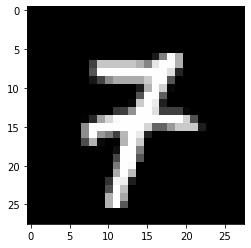

In [80]:
idx = torch.randint(0,10000,(1,)).item()
print(idx)
img = testing_data[idx][0]
print(testing_data[idx][1])
plt.imshow(img.squeeze(), cmap='gray')

#Architecture for autoencoders


In [81]:
class Auto(nn.Module):
  def __init__(self):
    super(Auto, self).__init__()

    self.encode = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=64),
        nn.ReLU(),
    )

    self.decode = nn.Sequential(
        nn.Linear(in_features=64, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=784),
        nn.Sigmoid(),
    )

  def forward(self, x):
    # x = torch.flatten(x,1)
    # x = x.type(torch.float)
    # print(f"in forward call\n x type : {x}")
    out = self.encode(x)
    logits = self.decode(out)
    return logits

#hyperparams

In [82]:
learning_rate = 1e-4
batch_size = 64
epochs = 50

#Metrics

In [83]:
train_loss = []
test_loss = []
accuracy = []

#Dataloaders

In [84]:
train_dataloader = DataLoader(training_data, batch_size)
test_dataloader = DataLoader(testing_data, batch_size)

In [85]:
for batch, (X,y) in enumerate(train_dataloader):
  print(f" batch : {batch} \nx : {X}  y : {y}")

Streaming output truncated to the last 5000 lines.
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],

In [86]:
compressor = Auto().to(device)
compressor

Auto(
  (encode): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
  )
  (decode): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [87]:
# g = compressor.parameters()
# for i in g:
#   print(type(i[0][0].item()))
#   break

In [88]:
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(compressor.parameters(), lr=learning_rate)

In [89]:
def train_loop(dataloader, model, loss_fn, optimiser):
  size = len(dataloader.dataset)
  for batch, (X,y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    x = torch.flatten(X,1)
    print(f"in train_loop \n pred dim : {pred[0][0].dtype}   X dim : {X[0][0].dtype}  x dim : {x[0][0].dtype}  y dim : {y[0].dtype}")
    loss = loss_fn(pred, x)
    # print(f"in train_loop \n loss dim : {loss}")
    # backprop
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if batch % 100 == 0:
      tloss, current = loss.item(), batch * len(X)
      # print(f"batch: {batch}")
      print(f"loss: {tloss} [{current}/{size}]")
      # time.sleep(.5)
      plt.imshow(np.reshape(pred[0].cpu().detach().numpy(),(28,28)), cmap="gray")
      print(f"label: {y[0]}")
      # time.sleep(.5)
      # plt.imshow(np.reshape(x[0].cpu().detach().numpy(),(28,28)))
  return loss.float()

In [90]:
def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  avg_test_loss, correct_preds = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      loss += loss_fn(pred, torch.flatten(X,1)).item()

#optimsation loop

Streaming output truncated to the last 5000 lines.
 pred dim : torch.float32   X dim : torch.float32  x dim : torch.float32  y dim : torch.float64
in train_loop 
 pred dim : torch.float32   X dim : torch.float32  x dim : torch.float32  y dim : torch.float64
in train_loop 
 pred dim : torch.float32   X dim : torch.float32  x dim : torch.float32  y dim : torch.float64
in train_loop 
 pred dim : torch.float32   X dim : torch.float32  x dim : torch.float32  y dim : torch.float64
in train_loop 
 pred dim : torch.float32   X dim : torch.float32  x dim : torch.float32  y dim : torch.float64
in train_loop 
 pred dim : torch.float32   X dim : torch.float32  x dim : torch.float32  y dim : torch.float64
in train_loop 
 pred dim : torch.float32   X dim : torch.float32  x dim : torch.float32  y dim : torch.float64
in train_loop 
 pred dim : torch.float32   X dim : torch.float32  x dim : torch.float32  y dim : torch.float64
in train_loop 
 pred dim : torch.float32   X dim : torch.float32  x dim : to

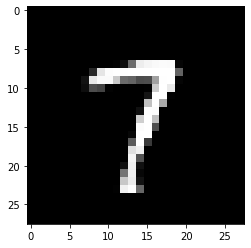

In [91]:
for e in range(50):
  print(f"epoch {e+1}\n-----------------------------------")
  compressor.train(True)
  loss = train_loop(train_dataloader, compressor, loss_fn, optimiser)
  print(f"loss : {loss.item()}")

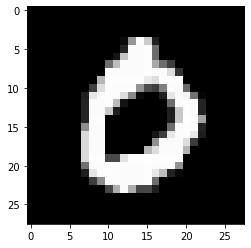

In [96]:
plt.imshow(testing_data[3][0].squeeze(), cmap="gray")


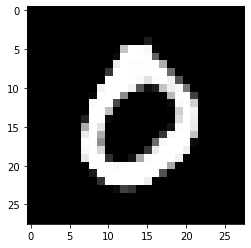

In [95]:
compressor.train(False)
compressor.eval()

with torch.no_grad():
  pred = compressor(testing_data[3][0].to(device))
  plt.imshow(np.reshape(pred[0].cpu().detach().numpy(),(28,28)), cmap="gray")

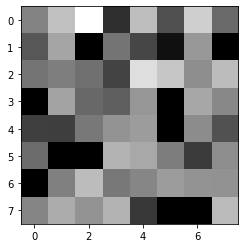

In [100]:
compressed_img = compressor.encode(testing_data[3][0].to(device))
img = compressed_img.cpu().detach().numpy()
img = img.squeeze()
img = np.reshape(img,(8,8))
plt.imshow(img,cmap="gray")

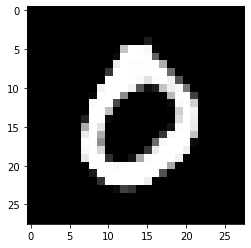

In [104]:
decomp_img = compressor.decode(compressed_img[0])
img = decomp_img.cpu().detach().numpy()
img = img.squeeze()
img = np.reshape(img,(28,28))
plt.imshow(img,cmap="gray")